# 각 data에 있는 공통 Gene mapping하고 추출하기.

In [6]:
import pandas as pd
import ast

In [ ]:
# --- 1. 데이터 불러오기 ---
kegg_df = pd.read_csv("C:/Users/hemoa/OneDrive/바탕 화면/비어플/[25-1] Medical/dataset/#_RE_DepMap_Kegg_info.csv")
ccle_df = pd.read_csv("C:/Users/hemoa/OneDrive/바탕 화면/비어플/[25-1] Medical/dataset/CCLE_gene_EdgeR.csv")
tcga_df = pd.read_csv("C:/Users/hemoa/OneDrive/바탕 화면/비어플/[25-1] Medical/dataset/TCGA/HiSeqV2_percentile_(BRCA).csv")

In [7]:
# --- 2. 전처리: KEGG NodeInfo, EdgeInfo 문자열 → 리스트 변환 ---
kegg_df['NodeInfo'] = kegg_df['NodeInfo'].apply(ast.literal_eval)
kegg_df['EdgeInfo'] = kegg_df['EdgeInfo'].apply(ast.literal_eval)

In [8]:
# --- 3. 각 데이터셋의 유전자 이름 정리 ---
# CCLE
ccle_df.columns = ccle_df.columns.str.replace(r"\s+\(\d+\)", "", regex=True)
ccle_genes = set(ccle_df.columns[1:])  # 첫 열 제외

# TCGA
tcga_df.columns = tcga_df.columns.str.replace(r"\s+\(\d+\)", "", regex=True)
tcga_genes = set(tcga_df.columns[1:])  # 첫 열 제외

# KEGG NodeInfo 전체 유전자
kegg_genes = set(gene for sublist in kegg_df['NodeInfo'] for gene in sublist)

In [9]:
# --- 4. 공통 유전자 추출 및 비교 ---
common_genes = kegg_genes & ccle_genes & tcga_genes

# 각각의 전체 유전자 수
print(f"[KEGG] 전체 유전자 수: {len(kegg_genes)}")
print(f"[CCLE] 전체 유전자 수: {len(ccle_genes)}")
print(f"[TCGA] 전체 유전자 수: {len(tcga_genes)}\n")

# 공통 유전자 수
print(f"[공통] 3개 데이터셋에 모두 존재하는 유전자 수: {len(common_genes)}\n")

# 각 데이터셋에만 있는 유전자
only_in_kegg = kegg_genes - (ccle_genes | tcga_genes)
only_in_ccle = ccle_genes - (kegg_genes | tcga_genes)
only_in_tcga = tcga_genes - (kegg_genes | ccle_genes)

print(f"[KEGG] KEGG에만 있는 유전자 수: {len(only_in_kegg)}")
print(f"[CCLE] CCLE에만 있는 유전자 수: {len(only_in_ccle)}")
print(f"[TCGA] TCGA에만 있는 유전자 수: {len(only_in_tcga)}")

[KEGG] 전체 유전자 수: 4209
[CCLE] 전체 유전자 수: 10927
[TCGA] 전체 유전자 수: 20541

[공통] 3개 데이터셋에 모두 존재하는 유전자 수: 2765

[KEGG] KEGG에만 있는 유전자 수: 234
[CCLE] CCLE에만 있는 유전자 수: 0
[TCGA] TCGA에만 있는 유전자 수: 8404


In [ ]:
# --- 5. KEGG: NodeInfo와 EdgeInfo 필터링 ---
# NodeInfo 필터링
kegg_df['NodeInfo'] = kegg_df['NodeInfo'].apply(lambda nodes: list(set(nodes) & common_genes))

# EdgeInfo 필터링 함수
def filter_edges(edges, valid_genes):
    return [edge for edge in edges if all(node in valid_genes for node in edge)]

# EdgeInfo 필터링
kegg_df['EdgeInfo'] = kegg_df.apply(
    lambda row: filter_edges(row['EdgeInfo'], set(row['NodeInfo'])),
    axis=1
)

In [22]:
# --- 6. 발현 데이터에서도 공통 유전자만 남기기 ---
first_col_ccle = ccle_df.columns[0]
first_col_tcga = tcga_df.columns[1]

ccle_filtered = ccle_df[[first_col_ccle] + sorted(list(common_genes & set(ccle_df.columns)))]
tcga_filtered = tcga_df[[first_col_tcga] + sorted(list(common_genes & set(tcga_df.columns)))]

In [25]:
kegg_df

,PathwayID,NodeInfo,EdgeInfo
0,hsa00010,"[GALM, GPI, ALDH2, HK1, PGM1, PDHA1, ALDH3A1, ...","[(PDHA1, DLAT), (HK1, GALM), (ALDOA, TPI1), (P..."
1,hsa00020,"[PDHA1, DLST, SDHA, IDH1, SUCLG2, DLD, DLAT, F...","[(MDH1, ACLY), (DLAT, PDHA1), (DLST, OGDH), (S..."
2,hsa00030,"[PGM2, SHPK, PFKL, GLYCTK, GPI, RPE, TALDO1, P...","[(RPIA, PGD), (TKT, PGM1), (SHPK, TKT), (PGM2,..."
3,hsa00040,"[CRYL1, UGP2, AKR1A1, RPE, XYLB, DCXR, GUSB, F...","[(AKR1A1, CRYL1), (UGP2, UGDH), (FGGY, RPE), (..."
4,hsa00051,"[PFKL, PMM1, GMPPB, ENOSF1, ALDOA, GMDS, FPGT,...","[(HK1, PMM1), (HK1, MPI), (AKR1B1, SORD), (GMD..."
...,...,...,...
308,hsa04934,"[GNAS, GNA11, NR4A1, E2F1, FH, LDLR, MAP2K1, C...","[(GSK3B, AXIN1), (PRKACA, SP1), (RAP1A, BRAF),..."
309,hsa01521,"[BCL2, STAT3, MET, PRKCA, BCL2L1, HRAS, VEGFA,...","[(EGFR, GAB1), (MAPK1, BCL2L11), (ERBB2, JAK1)..."
310,hsa01524,"[CASP3, BCL2, GSTO2, BIRC2, MDM2, MAP3K5, TP53...","[(BAD, BCL2), (TP53, BBC3), (CASP8, TP53), (BA..."
311,hsa01523,"[IL1B, GART, SLC46A1, ATIC, SLC19A1, ABCC4, CH...","[(CHUK, NFKB1), (NFKB1, IL1B)]"


In [26]:
ccle_filtered

,Unnamed: 0,A4GALT,AACS,AADAT,AASDHPPT,AASS,ABAT,ABCA1,ABCC1,ABCC2,...,ZFYVE9,ZMAT3,ZMPSTE24,ZNF274,ZNF385A,ZNF516,ZNF76,ZNFX1,ZNRF3,ZYX
0,ACH-000242,1815,6327,1055,2947,1115,3106,1021,6828,28,...,6384,1418,7417,1213,5812,1225,2784,4722,3584,4962
1,ACH-000327,7,11985,100,2562,177,25,165,4013,17436,...,1463,2750,7519,2915,706,1529,2074,2374,1320,2120
2,ACH-000233,4,2167,968,2342,19,376,4387,4050,473,...,176,2593,2512,1285,401,967,3148,4983,501,18346
3,ACH-000528,775,1911,403,5141,6,2182,6,2902,207,...,4992,5835,6369,1148,698,713,2125,3802,4736,2721
4,ACH-001655,600,2801,594,6196,3127,8,4155,5686,95,...,1495,1718,8411,4374,1581,1737,2487,6274,682,43403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,ACH-000114,736,3213,1249,2760,2658,1703,998,12183,117,...,1179,1765,2767,1668,424,1102,2144,9229,672,3662
690,ACH-001578,704,2634,775,6986,10798,1195,9868,8418,110,...,12783,7582,11966,2676,125,1950,2687,2023,1188,4002
691,ACH-000973,80,3634,850,5000,4193,712,197,5280,51,...,3659,1756,6007,2048,586,831,2120,3704,2563,12367
692,ACH-000750,2,1982,451,5667,3663,5,4841,4344,131,...,1888,3418,3902,2158,312,2549,1592,5708,785,12522


In [27]:
tcga_filtered

,sample,A4GALT,AACS,AADAT,AASDHPPT,AASS,ABAT,ABCA1,ABCC1,ABCC2,...,ZFYVE9,ZMAT3,ZMPSTE24,ZNF274,ZNF385A,ZNF516,ZNF76,ZNFX1,ZNRF3,ZYX
0,TCGA-AR-A5QQ-01,70.5421,74.6106,39.9686,76.5364,36.5649,35.7318,82.3680,82.1769,16.8445,...,53.2639,18.1797,81.2211,47.7775,87.8916,36.0456,65.7233,83.2097,51.4864,97.7603
1,TCGA-D8-A1JA-01,27.3460,77.6289,26.8003,83.5220,37.2899,52.2637,96.0992,83.6721,98.1839,...,69.7552,43.8211,96.7055,47.9789,65.8573,30.9147,45.5766,93.5815,47.0694,93.5295
2,TCGA-BH-A0BQ-01,53.0814,79.7189,24.8019,67.6415,42.3323,95.7329,55.8349,84.5533,8.1124,...,65.1417,32.5181,87.1815,47.0013,86.0527,59.9310,62.1914,89.6699,42.5631,97.9477
3,TCGA-BH-A0BT-01,46.4472,78.6124,20.1711,82.0714,65.5184,99.0365,48.5249,82.8331,6.7588,...,64.1399,30.1444,83.1514,64.2593,87.5568,29.8630,73.6556,88.8444,41.4961,91.9822
4,TCGA-A8-A06X-01,52.3570,81.8448,28.2250,71.5443,27.7636,80.9753,53.9333,91.2817,16.2950,...,27.7636,29.4168,88.1795,47.4330,44.1799,61.9034,58.8662,94.6265,45.0405,88.7443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,TCGA-A2-A3XT-01,88.5552,55.2555,31.6030,70.6854,28.8126,28.9584,58.5198,77.3235,18.2624,...,59.6023,35.4479,81.3927,50.4207,76.6139,29.8783,68.4980,78.0610,45.4428,96.7385
1214,TCGA-B6-A0X7-01,42.1054,66.3470,18.8059,59.8867,60.6068,65.7379,69.4661,75.1978,14.3178,...,59.9721,36.6270,86.1062,60.8316,85.3065,63.8170,67.6533,87.5719,47.5781,91.8464
1215,TCGA-BH-A1EV-11,42.1271,75.2052,39.8402,75.4596,76.9340,65.0974,92.5457,78.6984,19.4387,...,76.3678,51.4061,91.6922,58.3434,63.1442,56.5434,57.5008,87.7640,61.3853,94.3566
1216,TCGA-3C-AALJ-01,61.7034,83.6554,25.7726,68.9024,29.0345,52.0223,65.9926,84.4788,10.5948,...,39.4809,23.9801,74.6843,57.1932,90.8427,30.5884,63.5192,79.0083,44.8961,96.7992


In [28]:
# --- 7. 저장 ---
kegg_output_path = "./#_filtered_Kegg_info.csv"
ccle_output_path = "./#_filtered_CCLE_gene_expression.csv"
tcga_output_path = "./#_filtered_TCGA_gene_expression.csv"

kegg_df.to_csv(kegg_output_path, index=False)
ccle_filtered.to_csv(ccle_output_path, index=False)
tcga_filtered.to_csv(tcga_output_path, index=False)

print("모든 데이터가 공통 유전자로 필터링되어 저장되었습니다.")

모든 데이터가 공통 유전자로 필터링되어 저장되었습니다.


# Cell line 매핑하기(drug, gene_exp)

In [1]:
import pandas as pd

drug = pd.read_csv("C:/Users/hemoa/OneDrive/바탕 화면/비어플/[25-1] Medical/dataset/#_Drug-Cell-IC50.csv")

drug.info(), drug.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262289 entries, 0 to 262288
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      262289 non-null  int64  
 1   DATASET         262289 non-null  object 
 2   COSMIC_ID       262289 non-null  int64  
 3   ARXSPAN_ID      262289 non-null  object 
 4   DRUG_NAME       262289 non-null  object 
 5   IC50_PUBLISHED  262289 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 12.0+ MB


(None,
    Unnamed: 0 DATASET  COSMIC_ID  ARXSPAN_ID  DRUG_NAME  IC50_PUBLISHED
 0           5   GDSC1     684072  ACH-000087  ERLOTINIB        7.645605
 1           6   GDSC1     684681  ACH-000327  ERLOTINIB       53.896094
 2           7   GDSC1     687448  ACH-000644  ERLOTINIB       19.435650
 3           8   GDSC1     687562  ACH-000137  ERLOTINIB       12.121612
 4           9   GDSC1     687568  ACH-000738  ERLOTINIB       36.788489)

In [3]:
# 각 cell line별로 몇 개의 drug에 대한 IC50 값이 있는지 확인
cell_line_counts = drug.groupby("ARXSPAN_ID")["DRUG_NAME"].nunique().sort_values(ascending=False)


cell_line_counts.describe(), cell_line_counts.head(10)

(count    708.000000
 mean     314.124294
 std       57.151565
 min       23.000000
 25%      297.500000
 50%      334.000000
 75%      343.000000
 max      368.000000
 Name: DRUG_NAME, dtype: float64,
 ARXSPAN_ID
 ACH-000927    368
 ACH-001190    367
 ACH-000666    367
 ACH-000252    367
 ACH-000647    367
 ACH-000943    367
 ACH-000653    367
 ACH-000655    367
 ACH-000691    367
 ACH-000145    367
 Name: DRUG_NAME, dtype: int64)

* 총 cell line: 708개
* 각 cell line이 가진 drug 수
    * mean: 약 314개
    * min: 23개
    * max: 368개  

모든 cell line이 동일한 drug sample을 가지고 있는 것이 아님.

In [7]:
# IC50 값에 NaN이 있는지 확인
ic50_nan_count = drug["IC50_PUBLISHED"].isna().sum()

# 전체에서 NaN이 있는 행 비율도 같이 확인
ic50_nan_count, ic50_nan_count / len(drug)

(0, 0.0)

결측치는 없음.

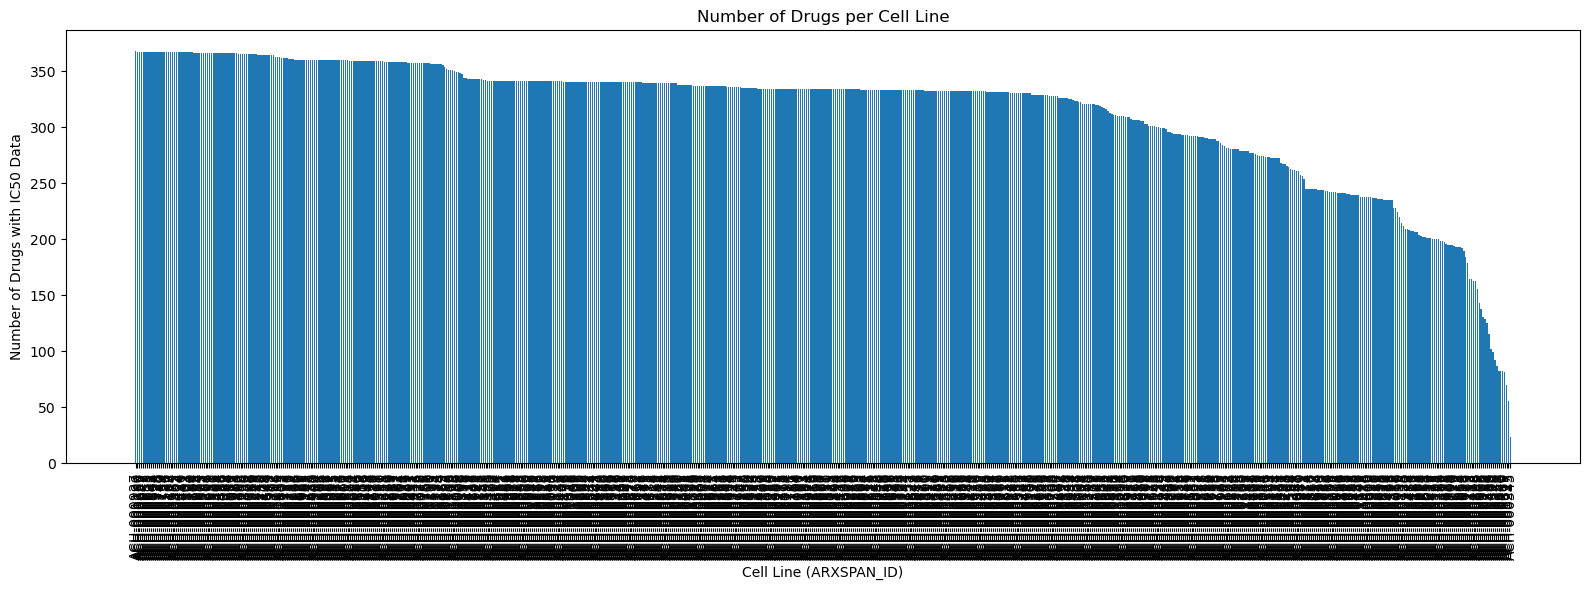

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.bar(cell_line_counts.index, cell_line_counts.values)
plt.title('Number of Drugs per Cell Line')
plt.xlabel('Cell Line (ARXSPAN_ID)')
plt.ylabel('Number of Drugs with IC50 Data')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## gene_expressing data와 drug_IC50 cell line 매핑

In [8]:
gene_expr_df = pd.read_csv("C:/Users/hemoa/OneDrive/바탕 화면/비어플/[25-1] Medical/dataset/preprocessing/#_filtered_CCLE_gene_expression.csv")

gene_expr_df.info(), gene_expr_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Columns: 2766 entries, Unnamed: 0 to ZYX
dtypes: float64(1), int64(2764), object(1)
memory usage: 14.6+ MB


(None,
    Unnamed: 0  A4GALT   AACS  AADAT  AASDHPPT  AASS  ABAT  ABCA1  ABCC1  \
 0  ACH-000242    1815   6327   1055      2947  1115  3106   1021   6828   
 1  ACH-000327       7  11985    100      2562   177    25    165   4013   
 2  ACH-000233       4   2167    968      2342    19   376   4387   4050   
 3  ACH-000528     775   1911    403      5141     6  2182      6   2902   
 4  ACH-001655     600   2801    594      6196  3127     8   4155   5686   
 
    ABCC2  ...  ZFYVE9  ZMAT3  ZMPSTE24  ZNF274  ZNF385A  ZNF516  ZNF76  ZNFX1  \
 0     28  ...    6384   1418      7417    1213     5812    1225   2784   4722   
 1  17436  ...    1463   2750      7519    2915      706    1529   2074   2374   
 2    473  ...     176   2593      2512    1285      401     967   3148   4983   
 3    207  ...    4992   5835      6369    1148      698     713   2125   3802   
 4     95  ...    1495   1718      8411    4374     1581    1737   2487   6274   
 
    ZNRF3    ZYX  
 0   3584   4962  
 1 

In [9]:
# 공통 cell line ID 추출
ic50_cell_lines = set(drug["ARXSPAN_ID"].unique())
gene_expr_cell_lines = set(gene_expr_df["Unnamed: 0"].unique())
common_cell_lines = ic50_cell_lines.intersection(gene_expr_cell_lines)

# 각각 필터링
drug_filtered = drug[drug["ARXSPAN_ID"].isin(common_cell_lines)]
gene_expr_df_filtered = gene_expr_df[gene_expr_df["Unnamed: 0"].isin(common_cell_lines)]

# 몇 개가 남았는지 확인
len(common_cell_lines), drug_filtered.shape, gene_expr_df_filtered.shape


(694, (257522, 6), (694, 2766))

In [12]:
# CSV 파일로 저장
drug_filtered.to_csv("C:/Users/hemoa/OneDrive/바탕 화면/비어플/[25-1] Medical/dataset/preprocessing/#_filtered_drug_IC50.csv", index=False)